In [13]:
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import os

In [2]:
# Parameters
data_dir = 'audios'  # Directory where your WAV files are located
sample_rate = 16000
batch_size = 32
epochs = 20
n_mfcc = 40
max_pad_len = 173 

In [3]:
classes = ["bed", "bird", "cat", "dog", "down", "eight", "five", "four", "go", "happy", "house", "left", "marvel", "nine", "no", "off", "on", "one", "right", "seven", "sheila", "six", "stop", "three", "tree", "two", "up", "wow", "yes", "zero"]
num_classes = len(classes)

In [4]:
# Function to load and preprocess data
def load_data(data_dir):
    X = []
    y = []
    #classes = os.listdir(data_dir)
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            
            # Load audio and extract MFCCs
            x, sr = librosa.load(file_path, sr=sample_rate)
            mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)
            
            # Fill the sequences so that they all have the same length
            if mfccs.shape[1] < max_pad_len:
                # Add zeros (padding) at the end to equalize the length
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
            elif mfccs.shape[1] > max_pad_len:
                # Trim the sequence if it is longer
                mfccs = mfccs[:, :max_pad_len]
                
            X.append(mfccs)
            y.append(i)
    
    X = np.array(X)
    y = np.array(y)
    
    # Add extra dimension to match model input (4D: samples, height, width, channels)
    X = X[..., np.newaxis]  # Convert from (samples, n_mfcc, time_steps) to (samples, n_mfcc, time_steps, 1)
    
    return X, to_categorical(y)

In [5]:
# Load data
X, y = load_data(data_dir)

In [6]:
# Splitting the data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(X.shape[1], X.shape[2], 1)

40 173 1


In [8]:
#define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout after the first convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout after the second convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout after the third convolutional block
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout before the final dense layer
    Dense(num_classes, activation='softmax')
])

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 171, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 83, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 41, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 41, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 39, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 19, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 19, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       934,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030,558 (3.93 MB)

 Trainable params: 1,030,558 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9545 - loss: 0.1701 - val_accuracy: 0.9947 - val_loss: 0.0190
Epoch 2/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9590 - loss: 0.1497 - val_accuracy: 0.9939 - val_loss: 0.0208
Epoch 3/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.9559 - loss: 0.1643 - val_accuracy: 0.9959 - val_loss: 0.0155
Epoch 4/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.9590 - loss: 0.1503 - val_accuracy: 0.9944 - val_loss: 0.0205
Epoch 5/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.9576 - loss: 0.1555 - val_accuracy: 0.9933 - val_loss: 0.0218
Epoch 6/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9574 - loss: 0.1657 - val_accuracy: 0.9940 - val_loss: 0.0172
Epoch 7/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9596 - loss: 0.1650 - val_accuracy: 0.9953 - val_loss: 0.0185
Epoch 8/20
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9606 -

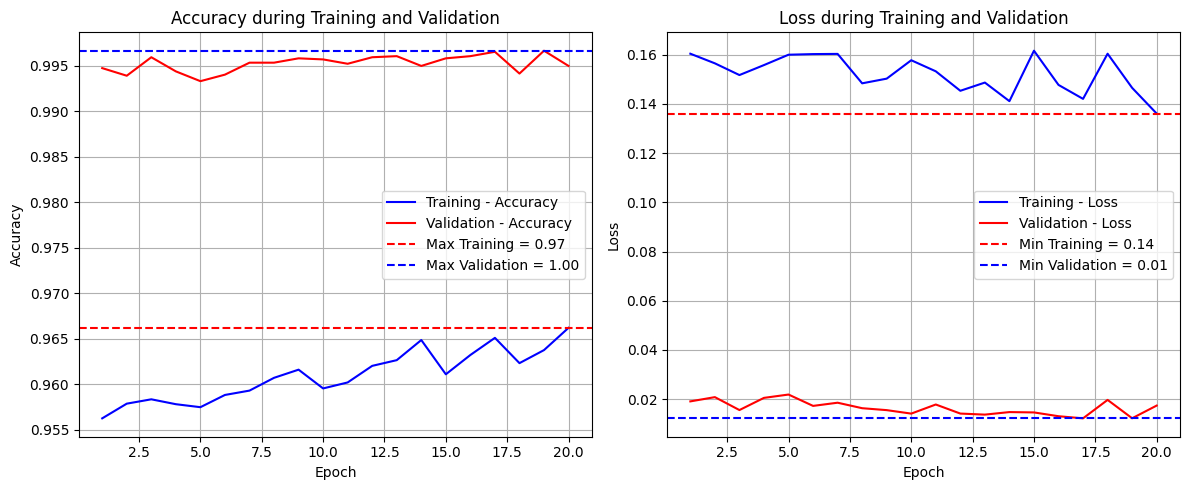

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)


training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
max_training_accuracy = max(training_accuracy)
max_validation_accuracy = max(validation_accuracy)


training_loss = history.history['loss']
validation_loss = history.history['val_loss']
min_training_loss = min(training_loss)
min_validation_loss = min(validation_loss)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, 'b-', label='Training - Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation - Accuracy')
plt.axhline(y=max_training_accuracy, color='r', linestyle='--', label=f'Max Training = {max_training_accuracy:.2f}')
plt.axhline(y=max_validation_accuracy, color='b', linestyle='--', label=f'Max Validation = {max_validation_accuracy:.2f}')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'b-', label='Training - Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation - Loss')
plt.axhline(y=min_training_loss, color='r', linestyle='--', label=f'Min Training = {min_training_loss:.2f}')
plt.axhline(y=min_validation_loss, color='b', linestyle='--', label=f'Min Validation = {min_validation_loss:.2f}')
plt.title('Loss during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# Save the trained model
model.save('keyphrase_detection_model.h5')